# <u><center> Simple Neural Networks Practice
* Authored by: Eric N. Valdez
* Date: 3-16-2024

# Assignment:
In this assignment, you will create a simple network using dense layers. You will also create 2 more versions of it where you adjust the number of layers and neurons per layer to see if you can achieve better performance.

Data Source: [Kaggle Heart Disease Dataset](https://www.kaggle.com/code/fedesoriano/heart-failure-prediction)

Direct link to data: [heart.csv](https://docs.google.com/spreadsheets/d/e/2PACX-1vTRfoQAojPwNsw33zUSpBg32DuK2z0WvLPptGOncIXa38tN3RWk9puvelcmsIIhFb_XF12RD7PdqCwf/pub?output=csv)

|Data Dictionary: | |
|---|---|
| Age: | age of the patient [years] |
| Sex: | sex of the patient [M: Male, F: Female] |
| ChestPainType: | chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic] |
| RestingBP: | resting blood pressure [mm Hg] |
| Cholesterol: | serum cholesterol [mm/dl] |
| FastingBS: | fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise] |
| RestingECG: | resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria] |
| MaxHR: | maximum heart rate achieved [Numeric value between 60 and 202] |
| ExerciseAngina: | exercise-induced angina [Y: Yes, N: No] |
| Oldpeak: | oldpeak = ST [Numeric value measured in depression] |
| ST_Slope: | the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping] |
| HeartDisease: | output class [1: heart disease, 0: Normal] |

# <u>Imports:

In [1]:
# imports
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from keras.layers import Dense
import matplotlib.pyplot as plt
import seaborn as sns

# <u>Custom Functions:

In [2]:
def plot_history(history, figsize=(6,12), marker='o'):

    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]

    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)

    # For each metric
    for i, metric_name in enumerate(metrics):

        # Get the axis for the current metric
        ax = axes[i]

        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch

        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)

        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)

        # Final subplot adjustments
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes

# <u>Load Data:

In [3]:
df = pd.read_csv('Data/heart - heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
# Looking at the info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [5]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [6]:
df.shape

(918, 12)

# <u>Task:
* Use a neural network to predict heart disease using the given data.

## `1. Explore and clean the data if needed.`

In [7]:
# Check for missing data
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [8]:
# check for duplicates
df.duplicated().sum()

0

* Data is clean with missing values and has no duplicates

## `2. Perform a train-test split on your data.`

In [9]:
# Train Test split
X = df.drop(columns='HeartDisease')
y = df['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [10]:
# Check class balance
y_train.value_counts(normalize=True)

1    0.546512
0    0.453488
Name: HeartDisease, dtype: float64

## `3. Use a column transformer to scale the numeric features and one-hot encode the categorical features.`

In [11]:
# create preprocessor
cat_select = make_column_selector(dtype_include='object')
num_select = make_column_selector(dtype_include='number')

scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore')

num_tuple = ('num', scaler, num_select)
cat_tuple = ('cat', ohe, cat_select)

processor = ColumnTransformer([num_tuple, cat_tuple], remainder='passthrough')

In [12]:
# process the data
X_train_processed = processor.fit_transform(X_train)
X_test_processed = processor.transform(X_test)

### <u>Model 1:
4. Define your base sequential model.¶
5. Include the number of features in your input layer
6. Use the correct activation function and the correct number of neuronsfor your output layer.
7. Compile your model with the correct loss and an optimizer ('adam' is a fine choice)

In [13]:
# create and compile the model
model = keras.Sequential()
model.add(Dense(10, input_dim=X_train_processed.shape[1],
          activation = 'relu'))
model.add(Dense(5, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = 'bce', metrics = 'accuracy')

#### `8. Include a validation split when fitting the model.`

In [14]:
# train the model and save the history
history = model.fit(X_train_processed, y_train,
          validation_split=.2,
          epochs = 10)

Epoch 1/10
18/18 [==============================] - 2s 17ms/step - loss: 0.6921 - accuracy: 0.5618 - val_loss: 0.7007 - val_accuracy: 0.5072
Epoch 2/10
18/18 [==============================] - 0s 4ms/step - loss: 0.6512 - accuracy: 0.5782 - val_loss: 0.6659 - val_accuracy: 0.5217
Epoch 3/10
18/18 [==============================] - 0s 4ms/step - loss: 0.6191 - accuracy: 0.5964 - val_loss: 0.6398 - val_accuracy: 0.5507
Epoch 4/10
18/18 [==============================] - 0s 4ms/step - loss: 0.5907 - accuracy: 0.6255 - val_loss: 0.6184 - val_accuracy: 0.5870
Epoch 5/10
18/18 [==============================] - 0s 4ms/step - loss: 0.5649 - accuracy: 0.6691 - val_loss: 0.6032 - val_accuracy: 0.6304
Epoch 6/10
18/18 [==============================] - 0s 4ms/step - loss: 0.5419 - accuracy: 0.7200 - val_loss: 0.5882 - val_accuracy: 0.7029
Epoch 7/10
18/18 [==============================] - 0s 4ms/step - loss: 0.5238 - accuracy: 0.7691 - val_loss: 0.5780 - val_accuracy: 0.7319
Epoch 8/10
18/18 [=

#### `9. Plot your model’s training history.`

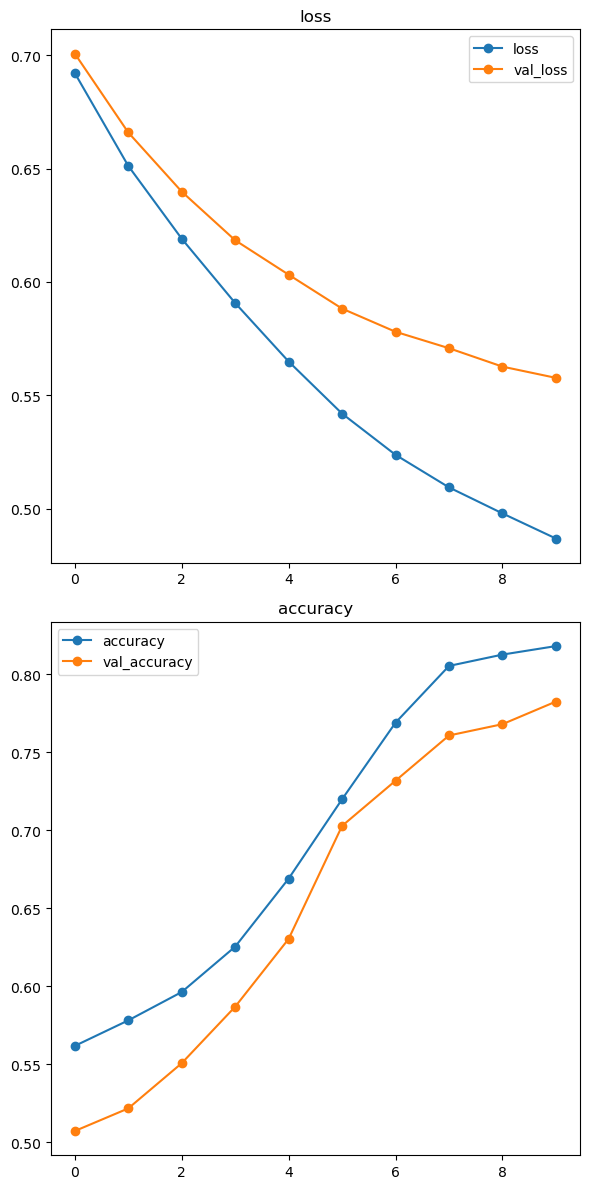

In [15]:
# Obtain history
plot_history(history);

#### `10. Evaluate your models with appropriate metrics.`

In [16]:
# Evaluate neural network with builtin evaluation
result = model.evaluate(X_test_processed, y_test,return_dict=True)
result

8/8 [==============================] - 0s 2ms/step - loss: 0.4713 - accuracy: 0.8435


{'loss': 0.4713309109210968, 'accuracy': 0.843478262424469}

8/8 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.89      0.72      0.80        98
           1       0.82      0.93      0.87       132

    accuracy                           0.84       230
   macro avg       0.85      0.83      0.84       230
weighted avg       0.85      0.84      0.84       230



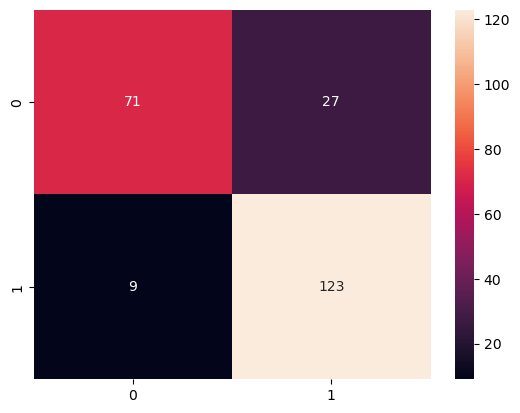

In [17]:
# evaluate the model with sklearn metrics
test_preds = model.predict(X_test_processed).round()
print(classification_report(y_test, test_preds))
conf_mat = confusion_matrix(y_test, test_preds)
sns.heatmap(conf_mat, annot=True, fmt ='g');

### <u>Model 2: More Neurons
4. Define your base sequential model.¶
5. Include the number of features in your input layer
6. Use the correct activation function and the correct number of neuronsfor your output layer.
7. Compile your model with the correct loss and an optimizer ('adam' is a fine choice)

In [18]:
# create model
model2 = keras.Sequential()
model2.add(Dense(20, input_dim=X_train_processed.shape[1],
          activation = 'relu'))
model2.add(Dense(5, activation = 'relu'))
model2.add(Dense(1, activation = 'sigmoid'))

model2.compile(optimizer = 'adam', loss = 'bce', metrics = 'accuracy')

#### `8. Include a validation split when fitting the model.`

In [19]:
# train the model and save the history
history = model2.fit(X_train_processed, y_train,
          validation_split=(.2),
          epochs = 10)

Epoch 1/10
18/18 [==============================] - 2s 20ms/step - loss: 0.6965 - accuracy: 0.4873 - val_loss: 0.6677 - val_accuracy: 0.6087
Epoch 2/10
18/18 [==============================] - 0s 4ms/step - loss: 0.6264 - accuracy: 0.7055 - val_loss: 0.6170 - val_accuracy: 0.6957
Epoch 3/10
18/18 [==============================] - 0s 4ms/step - loss: 0.5679 - accuracy: 0.7927 - val_loss: 0.5729 - val_accuracy: 0.7536
Epoch 4/10
18/18 [==============================] - 0s 4ms/step - loss: 0.5176 - accuracy: 0.8073 - val_loss: 0.5333 - val_accuracy: 0.7681
Epoch 5/10
18/18 [==============================] - 0s 5ms/step - loss: 0.4702 - accuracy: 0.8236 - val_loss: 0.4997 - val_accuracy: 0.7899
Epoch 6/10
18/18 [==============================] - 0s 4ms/step - loss: 0.4328 - accuracy: 0.8309 - val_loss: 0.4686 - val_accuracy: 0.7899
Epoch 7/10
18/18 [==============================] - 0s 4ms/step - loss: 0.4015 - accuracy: 0.8418 - val_loss: 0.4426 - val_accuracy: 0.7971
Epoch 8/10
18/18 [=

#### `9. Plot your model’s training history.`

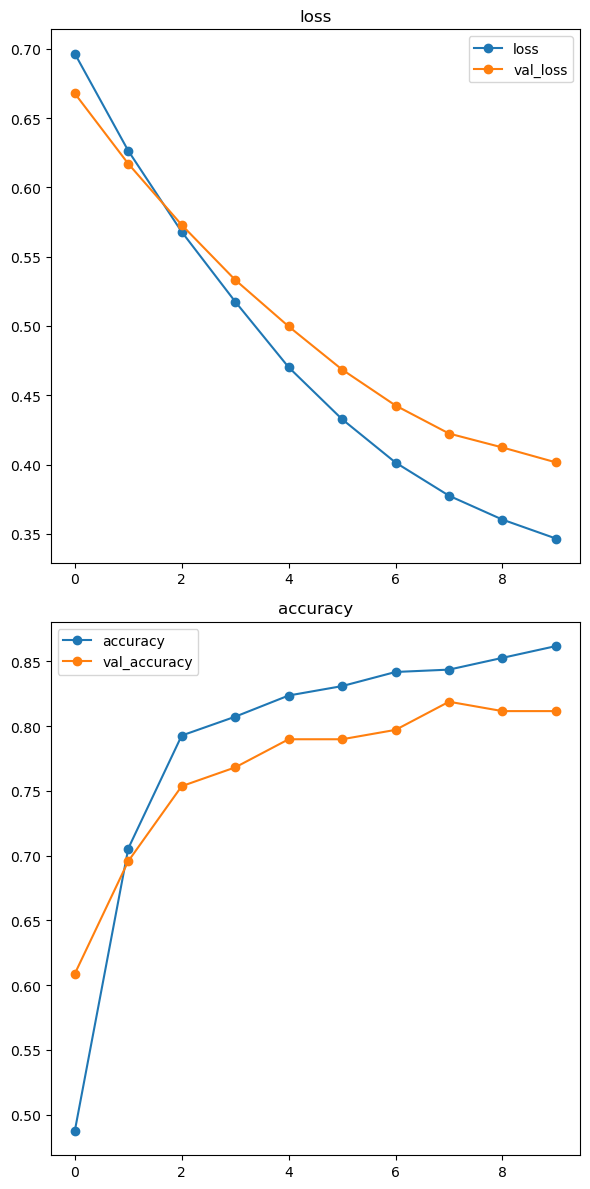

In [20]:
plot_history(history);

#### `10. Evaluate your models with appropriate metrics.`

In [21]:
# Evaluate neural network with builtin evaluation
result = model2.evaluate(X_test_processed, y_test,return_dict=True)
result

8/8 [==============================] - 0s 2ms/step - loss: 0.3699 - accuracy: 0.8565


{'loss': 0.36987918615341187, 'accuracy': 0.856521725654602}

8/8 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        98
           1       0.90      0.85      0.87       132

    accuracy                           0.86       230
   macro avg       0.85      0.86      0.85       230
weighted avg       0.86      0.86      0.86       230



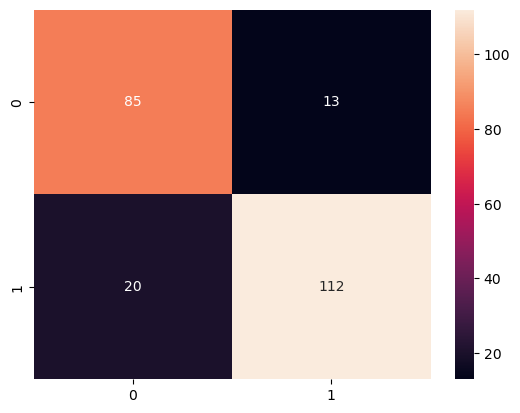

In [22]:
# evaluate the model with sklearn metrics
test_preds = model2.predict(X_test_processed).round()
print(classification_report(y_test, test_preds))
conf_mat = confusion_matrix(y_test, test_preds)
sns.heatmap(conf_mat, annot=True, fmt = 'g');

### <u>Model 3: More layers
4. Define your base sequential model.¶
5. Include the number of features in your input layer
6. Use the correct activation function and the correct number of neuronsfor your output layer.
7. Compile your model with the correct loss and an optimizer ('adam' is a fine choice)

In [23]:
# create model
model3 = keras.Sequential()
model3.add(Dense(20, input_dim=X_train_processed.shape[1],
        activation = 'relu'))
model3.add(Dense(5, activation = 'relu'))
model3.add(Dense(5, activation = 'relu'))
model3.add(Dense(1, activation = 'sigmoid'))

model3.compile(optimizer = 'adam', loss = 'bce', metrics = 'accuracy')

#### `8. Include a validation split when fitting the model.`

In [24]:
# train the model and save the history
history = model3.fit(X_train_processed, y_train,
          validation_split = .2,
          epochs = 10)

Epoch 1/10
18/18 [==============================] - 2s 17ms/step - loss: 0.6594 - accuracy: 0.6109 - val_loss: 0.5735 - val_accuracy: 0.7681
Epoch 2/10
18/18 [==============================] - 0s 6ms/step - loss: 0.5516 - accuracy: 0.7782 - val_loss: 0.5168 - val_accuracy: 0.8261
Epoch 3/10
18/18 [==============================] - 0s 6ms/step - loss: 0.4874 - accuracy: 0.8036 - val_loss: 0.4682 - val_accuracy: 0.8406
Epoch 4/10
18/18 [==============================] - 0s 6ms/step - loss: 0.4374 - accuracy: 0.8109 - val_loss: 0.4373 - val_accuracy: 0.8261
Epoch 5/10
18/18 [==============================] - 0s 6ms/step - loss: 0.4027 - accuracy: 0.8345 - val_loss: 0.4148 - val_accuracy: 0.8333
Epoch 6/10
18/18 [==============================] - 0s 7ms/step - loss: 0.3785 - accuracy: 0.8455 - val_loss: 0.3957 - val_accuracy: 0.8478
Epoch 7/10
18/18 [==============================] - 0s 7ms/step - loss: 0.3603 - accuracy: 0.8473 - val_loss: 0.3827 - val_accuracy: 0.8623
Epoch 8/10
18/18 [=

#### `9. Plot your model’s training history.`

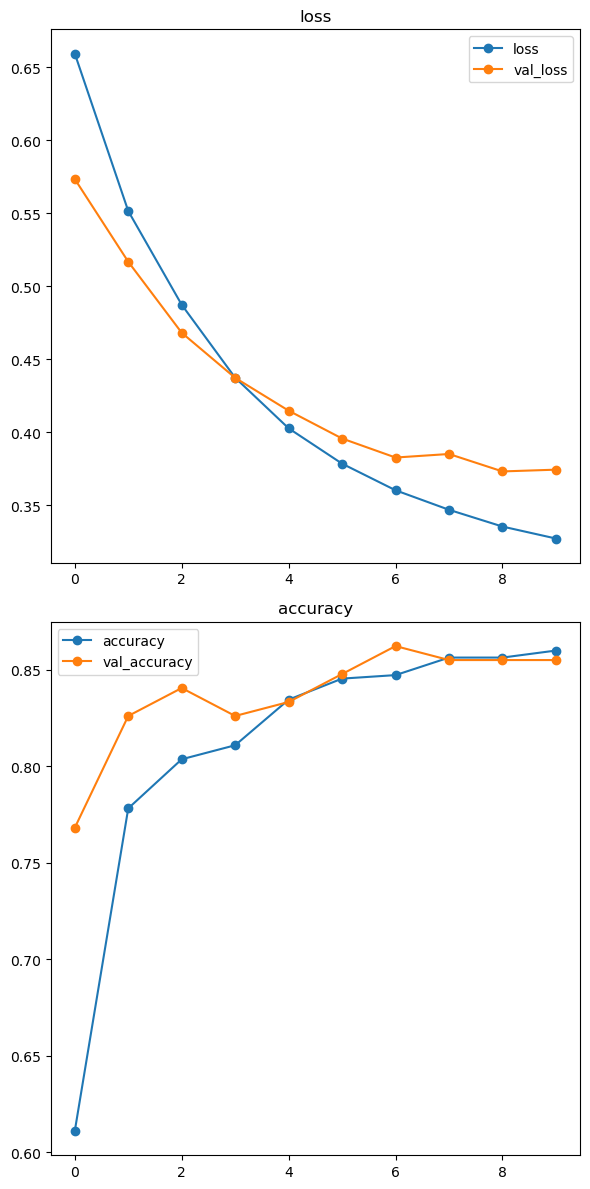

In [25]:
# Obtain history
plot_history(history);

#### `10. Evaluate your models with appropriate metrics.`

In [26]:
# Evaluate neural network with builtin evaluation
result = model3.evaluate(X_test_processed, y_test,return_dict=True)
result

8/8 [==============================] - 0s 2ms/step - loss: 0.3578 - accuracy: 0.8522


{'loss': 0.3577633202075958, 'accuracy': 0.852173924446106}

8/8 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.81      0.86      0.83        98
           1       0.89      0.85      0.87       132

    accuracy                           0.85       230
   macro avg       0.85      0.85      0.85       230
weighted avg       0.85      0.85      0.85       230



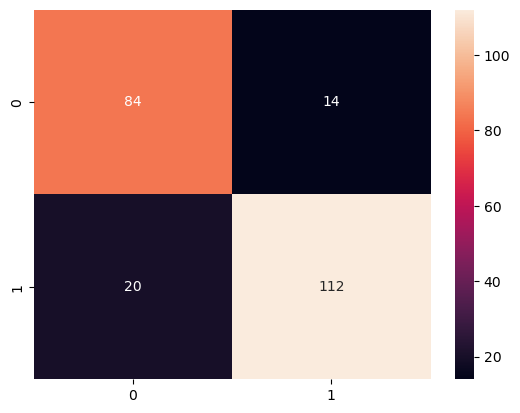

In [27]:
# evaluate the model
test_preds = model3.predict(X_test_processed).round()
print(classification_report(y_test, test_preds))
conf_mat = confusion_matrix(y_test, test_preds)
sns.heatmap(conf_mat, annot=True, fmt ='g');

- ### Model 2 seemed to have the better results than the other 2 models